# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1 : Propiedades en Venta</center>
## <center>Parte 3</center>
### <center> Grupo 22 </center>
### <center> Integrantes: </center>
##### <center> Federico Martin Forte,  Francisco Sobral,  Ian Klaus von der Heyde,  Juan Pablo Aschieri,  Joaquin Rivero  </center>

# Carga de Datos y librerías

In [165]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gp
import sklearn as sk

from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV, GridSearchCV, cross_validate, train_test_split
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import make_scorer, confusion_matrix, classification_report, precision_recall_curve, roc_curve, recall_score, accuracy_score,f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.preprocessing import StandardScaler


In [166]:
viviendas_caba_train=pd.read_csv('./Datasets/viviendas_caba_train.csv').copy()
viviendas_caba_test=pd.read_csv('./Datasets/viviendas_caba_test.csv').copy()
poly = gp.read_file(r'./Datasets/barrios_procesados.geojson')

# 3. Clasificación

### a. Construcción del target

La idea de este Trabajo es poder predecir el precio de una propiedad.  
El tipo de precio puede ser alto, medio o bajo, y para evaluar el mismo vamos a generarnos una nueva variable en el dataset, que sea el precio por metro cuadrado.

In [167]:
viviendas_caba_train['pxm2'] = viviendas_caba_train.property_price / viviendas_caba_train.property_surface_total
viviendas_caba_test['pxm2'] = viviendas_caba_test.property_price / viviendas_caba_test.property_surface_total
viviendas_caba_train.head()

start_date    end_date    latitud   longitud         barrio property_type  \
0  2021-12-15  2021-12-25 -34.555049 -58.490513       Saavedra  Departamento   
1  2021-05-20  2021-06-05 -34.546991 -58.478553       Saavedra  Departamento   
2  2021-03-20  2021-04-16 -34.570842 -58.491805  Villa Urquiza  Departamento   
3  2021-07-17  2021-10-16 -34.589251 -58.402106       Recoleta  Departamento   
4  2021-07-02  2022-02-09 -34.626290 -58.437632      Caballito  Departamento   

   property_rooms  property_bedrooms  property_surface_total  \
0             2.0                1.0                    58.0   
1             2.0                1.0                    48.0   
2             2.0                1.0                    62.0   
3             3.0                2.0                    60.0   
4             3.0                2.0                    67.0   

   property_surface_covered  property_price  \
0                      49.0        167113.0   
1                      44.0        129000.0   
2                      58.0        124600.0   
3                      60.0        196000.0   
4                      61.0        235000.0   

                                      property_title  \
0                            Departamento - Saavedra   
1                            Departamento - Saavedra   
2  Venta Depto 2 amb Anticipo + Cuotas CAC V. Urq...   
3  Excelente 3 ambientes en venta en Barrio Recoleta   
4             VENTA DEPARTAMENTO 3 AMB. EN CABALLITO   

                          geometry         pxm2  
0  POINT (-58.4905135 -34.5550487)  2881.258621  
1   POINT (-58.4785532 -34.546991)  2687.500000  
2  POINT (-58.4918048 -34.5708421)  2009.677419  
3  POINT (-58.4021058 -34.5892511)  3266.666667  
4  POINT (-58.4376325 -34.6262899)  3507.462687

Para evaluar el tipo de precio, procedemos a subclasificar el precio por metro cuadrado segun las cantidades de observaciones.  
Primero lo hacemos con cantidad igual de observaciones y luego dividimos en cuartiles , el primero con el 25% de las observaciones, el siguiente con el 50% y el último con el 25% de las observaciones restantes.  
Finalmente selecionaremos cada tipo de propiedad y haremos las mismas divisiones mencionadas.

In [168]:
labels=["Bajo","Medio","Alto"]

viviendas_caba_train["tipo_precio_igual_frec"], viviendas_caba_train_bins_igual_frec = pd.qcut(viviendas_caba_train["pxm2"],q=3, labels=labels, retbins=True)
viviendas_caba_train["tipo_precio_cuartiles"], viviendas_caba_train_bins_cuartiles = pd.qcut(viviendas_caba_train["pxm2"],q=[0,0.25,0.75,1], labels=labels, retbins=True)
viviendas_agrupada_tipo_precio_igual_frec = viviendas_caba_train.groupby(["tipo_precio_igual_frec"]).count()
viviendas_agrupada_tipo_precio_cuartiles = viviendas_caba_train.groupby(["tipo_precio_cuartiles"]).count()

viviendas_caba_train_depto = viviendas_caba_train.loc[viviendas_caba_train["property_type"]=="Departamento"].copy()
viviendas_caba_train_depto["tipo_precio_igual_frec"], viviendas_caba_train_depto_bins_igual_frec = pd.qcut(viviendas_caba_train_depto["pxm2"],q=3, labels=labels, retbins=True)
viviendas_caba_train_depto["tipo_precio_cuartiles"], viviendas_caba_train_depto_bins_cuartiles = pd.qcut(viviendas_caba_train_depto["pxm2"],q=[0,0.25,0.75,1], labels=labels, retbins=True)
deptos_agrupado_tipo_precio_igual_frec = viviendas_caba_train_depto.groupby(["tipo_precio_igual_frec"]).count()
deptos_agrupado_tipo_precio_cuartiles = viviendas_caba_train_depto.groupby(["tipo_precio_cuartiles"]).count()

viviendas_caba_train_ph = viviendas_caba_train.loc[viviendas_caba_train["property_type"]=="PH"].copy()
viviendas_caba_train_ph["tipo_precio_igual_frec"], viviendas_caba_train_ph_bins_igual_frec = pd.qcut(viviendas_caba_train_ph["pxm2"],q=3, labels=labels, retbins=True)
viviendas_caba_train_ph["tipo_precio_cuartiles"], viviendas_caba_train_ph_bins_cuartiles = pd.qcut(viviendas_caba_train_ph["pxm2"],q=[0,0.25,0.75,1], labels=labels, retbins=True)
ph_agrupado_tipo_precio_igual_frec = viviendas_caba_train_ph.groupby(["tipo_precio_igual_frec"]).count()
ph_agrupado_tipo_precio_cuartiles = viviendas_caba_train_ph.groupby(["tipo_precio_cuartiles"]).count()

viviendas_caba_train_casa = viviendas_caba_train.loc[viviendas_caba_train["property_type"]=="Casa"].copy()
viviendas_caba_train_casa["tipo_precio_igual_frec"], viviendas_caba_train_casa_bins_igual_frec = pd.qcut(viviendas_caba_train_casa["pxm2"],q=3, labels=labels, retbins=True)
viviendas_caba_train_casa["tipo_precio_cuartiles"], viviendas_caba_train_casa_bins_cuartiles = pd.qcut(viviendas_caba_train_casa["pxm2"],q=[0,0.25,0.75,1], labels=labels, retbins=True)
casas_agrupada_tipo_precio_igual_frec = viviendas_caba_train_casa.groupby(["tipo_precio_igual_frec"]).count()
casas_agrupada_tipo_precio_cuartiles = viviendas_caba_train_casa.groupby(["tipo_precio_cuartiles"]).count()



Y ahora graficamos segun los intervalos obtenidos

[Text(0.5, 1.0, 'Intervalos de viviendas por igual frecuencia'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

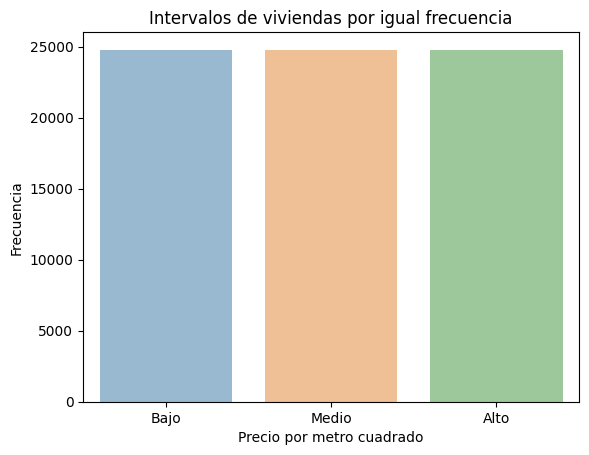

In [169]:
eje_x = viviendas_agrupada_tipo_precio_igual_frec.index.tolist()
eje_y = viviendas_agrupada_tipo_precio_igual_frec['pxm2'].tolist()

sns.barplot(x=eje_x, y=eje_y, data=viviendas_agrupada_tipo_precio_igual_frec ,alpha=0.5).set(title="Intervalos de viviendas por igual frecuencia",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

[Text(0.5, 1.0, 'Intervalos de viviendas por cuartiles'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

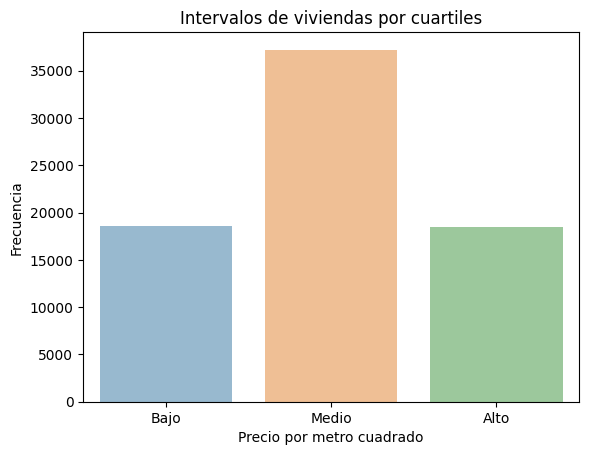

In [170]:
eje_x = viviendas_agrupada_tipo_precio_cuartiles.index.tolist()
eje_y = viviendas_agrupada_tipo_precio_cuartiles['pxm2'].tolist()
sns.barplot(x=eje_x, y=eje_y, data=viviendas_agrupada_tipo_precio_cuartiles ,alpha=0.5).set(title="Intervalos de viviendas por cuartiles",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

[Text(0.5, 1.0, 'Intervalos de Departamentos por igual frecuencia'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

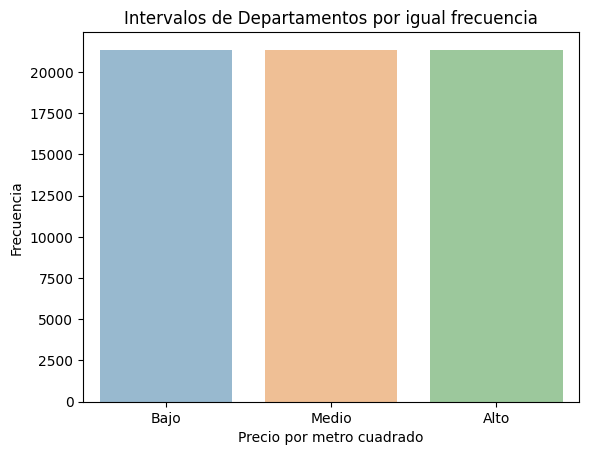

In [171]:
eje_x = deptos_agrupado_tipo_precio_igual_frec.index.tolist()
eje_y = deptos_agrupado_tipo_precio_igual_frec['pxm2'].tolist()

sns.barplot(x=eje_x, y=eje_y, data=deptos_agrupado_tipo_precio_igual_frec ,alpha=0.5).set(title="Intervalos de Departamentos por igual frecuencia",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

[Text(0.5, 1.0, 'Intervalos de Departamentos por cuartiles'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

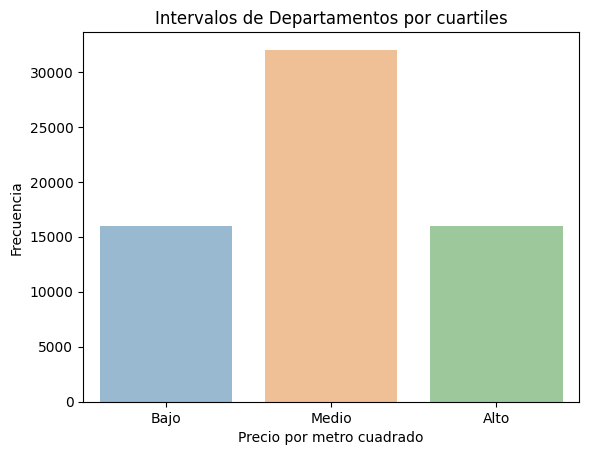

In [172]:
eje_x = deptos_agrupado_tipo_precio_cuartiles.index.tolist()
eje_y = deptos_agrupado_tipo_precio_cuartiles['pxm2'].tolist()
sns.barplot(x=eje_x, y=eje_y, data=deptos_agrupado_tipo_precio_cuartiles ,alpha=0.5).set(title="Intervalos de Departamentos por cuartiles",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

[Text(0.5, 1.0, 'Intervalos de PH por igual frecuencia'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

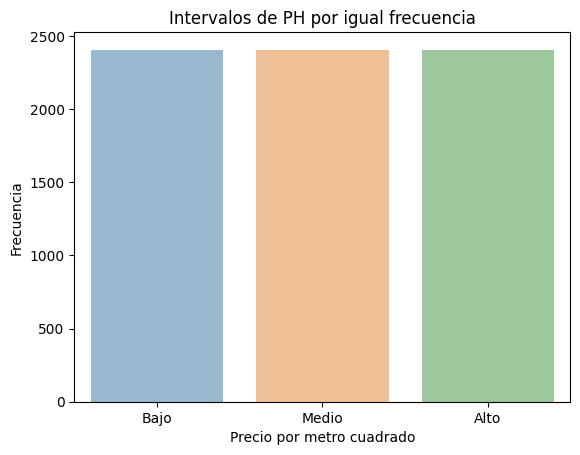

In [173]:
eje_x = ph_agrupado_tipo_precio_igual_frec.index.tolist()
eje_y = ph_agrupado_tipo_precio_igual_frec['pxm2'].tolist()

sns.barplot(x=eje_x, y=eje_y, data=ph_agrupado_tipo_precio_igual_frec ,alpha=0.5).set(title="Intervalos de PH por igual frecuencia",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')


[Text(0.5, 1.0, 'Intervalos de PH por cuartiles'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

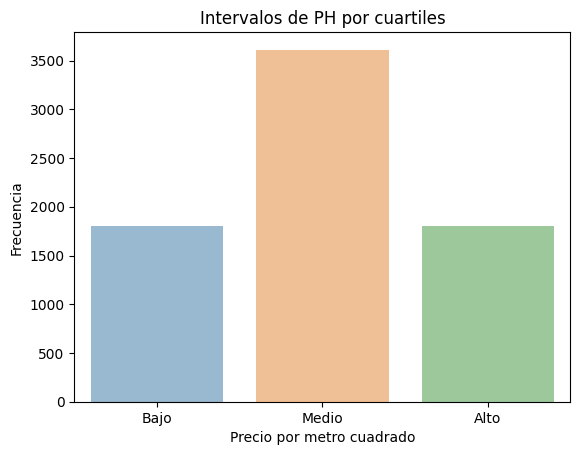

In [174]:
eje_x = ph_agrupado_tipo_precio_cuartiles.index.tolist()
eje_y = ph_agrupado_tipo_precio_cuartiles['pxm2'].tolist()
sns.barplot(x=eje_x, y=eje_y, data=ph_agrupado_tipo_precio_cuartiles ,alpha=0.5).set(title="Intervalos de PH por cuartiles",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

[Text(0.5, 1.0, 'Intervalos de Casas por igual frecuencia'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

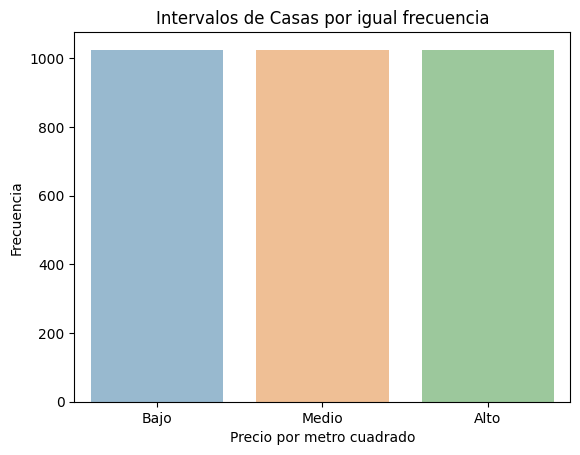

In [175]:
eje_x = casas_agrupada_tipo_precio_igual_frec.index.tolist()
eje_y = casas_agrupada_tipo_precio_igual_frec['pxm2'].tolist()

sns.barplot(x=eje_x, y=eje_y, data=casas_agrupada_tipo_precio_igual_frec ,alpha=0.5).set(title="Intervalos de Casas por igual frecuencia",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')



[Text(0.5, 1.0, 'Intervalos de Casas por cuartiles'),
 Text(0, 0.5, 'Frecuencia'),
 Text(0.5, 0, 'Precio por metro cuadrado')]

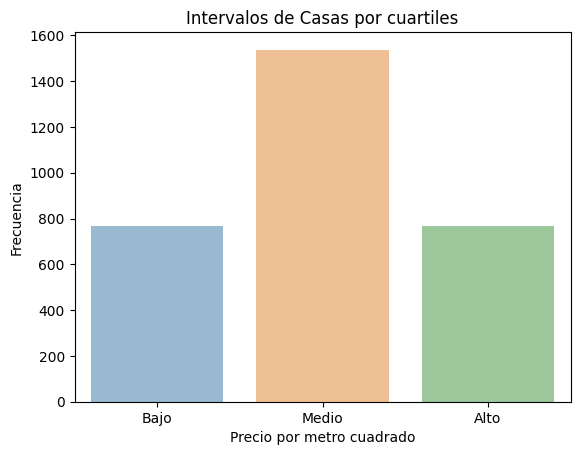

In [176]:
eje_x = casas_agrupada_tipo_precio_cuartiles.index.tolist()
eje_y = casas_agrupada_tipo_precio_cuartiles['pxm2'].tolist()
sns.barplot(x=eje_x, y=eje_y, data=casas_agrupada_tipo_precio_cuartiles ,alpha=0.5).set(title="Intervalos de Casas por cuartiles",ylabel='Frecuencia',xlabel='Precio por metro cuadrado')

Para darnos una idea del target, vamos a mostrar la distribución del precio de las viviendas de todo el dataset.


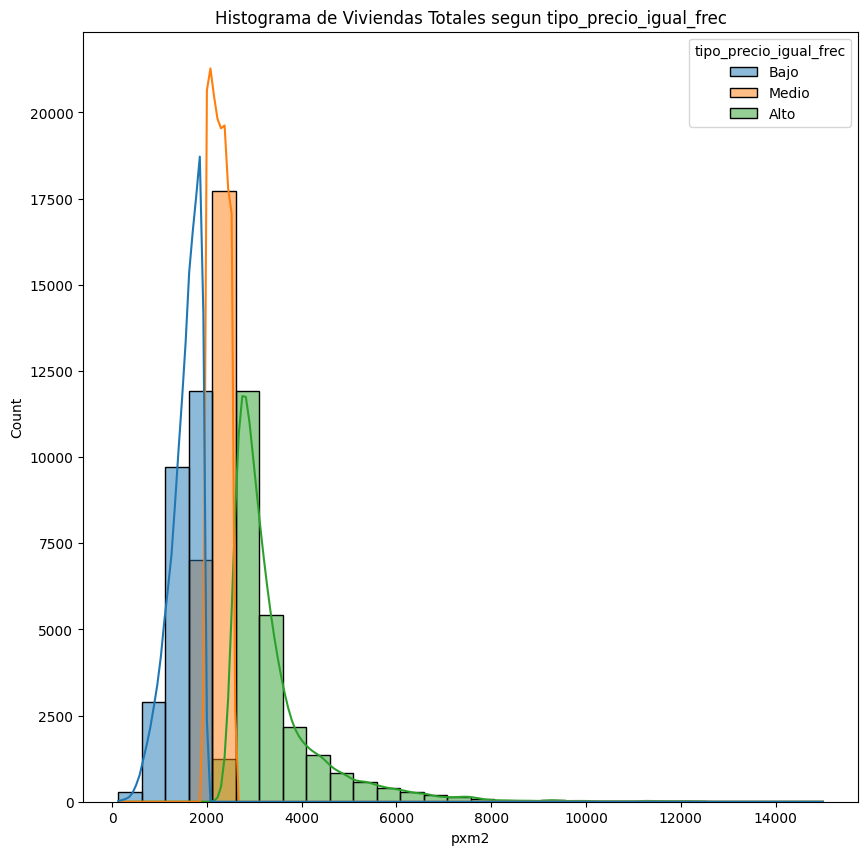

In [177]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Histograma de Viviendas Totales segun tipo_precio_igual_frec')
sns.histplot(data = viviendas_caba_train, x ='pxm2', hue = 'tipo_precio_igual_frec', bins=30, kde=True)
plt.show()

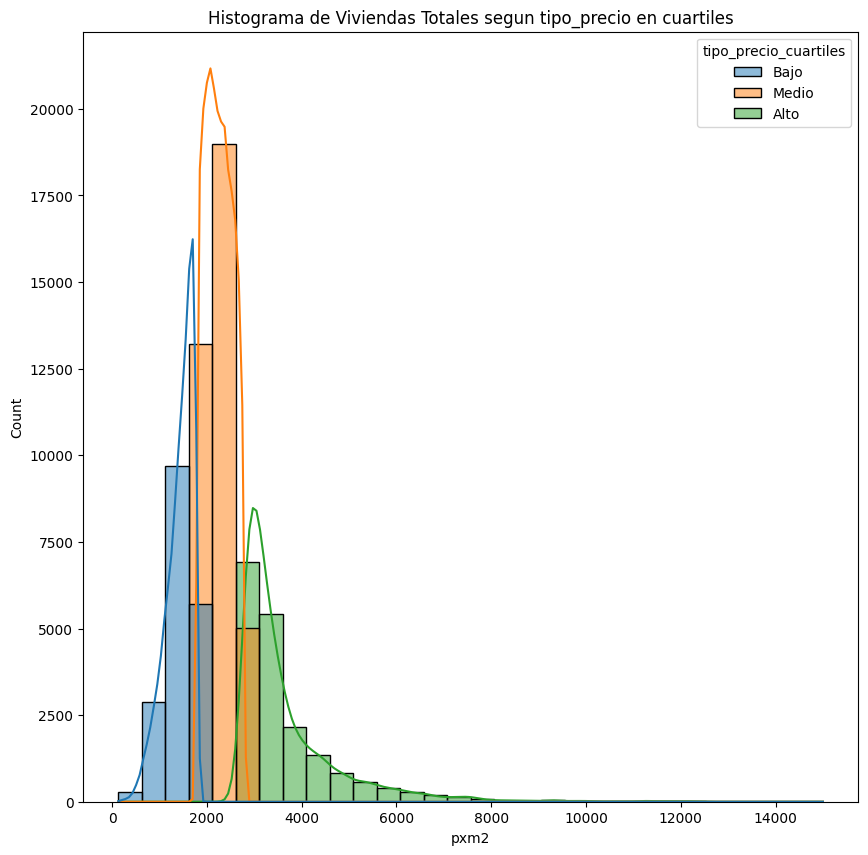

In [178]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Histograma de Viviendas Totales segun tipo_precio en cuartiles')
sns.histplot(data = viviendas_caba_train, x ='pxm2', hue = 'tipo_precio_cuartiles', bins=30, kde=True)
plt.show()

Ahora vamos a hacer lo mismo para cada tipo de propiedad

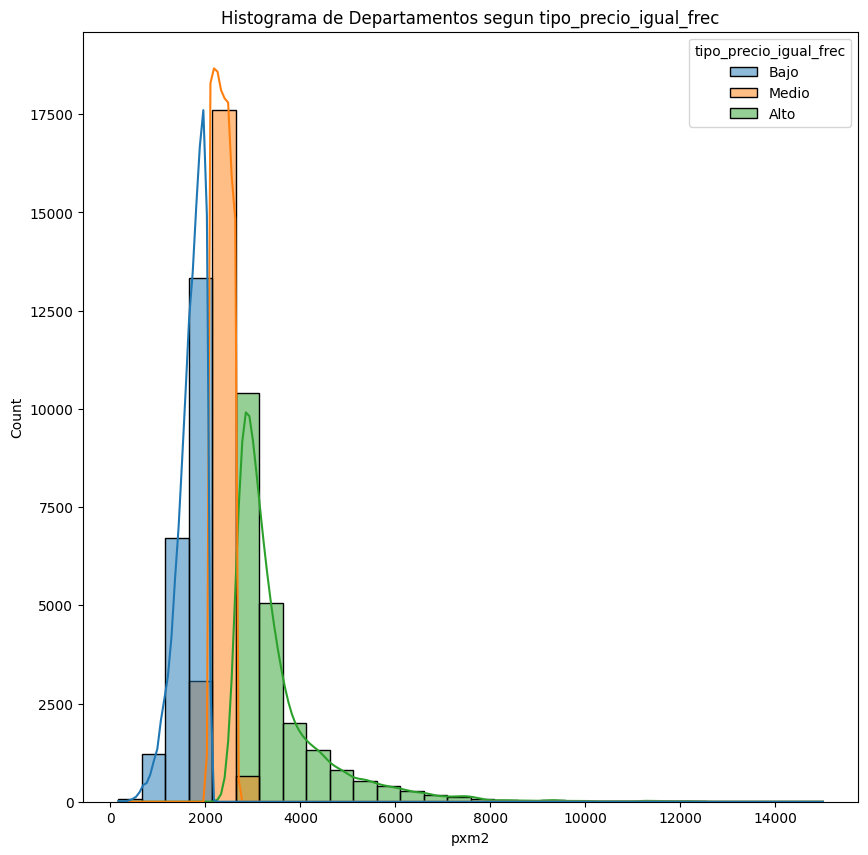

In [179]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Histograma de Departamentos segun tipo_precio_igual_frec')
sns.histplot(data = viviendas_caba_train_depto, x ='pxm2', hue = 'tipo_precio_igual_frec', bins=30, kde=True)
plt.show()

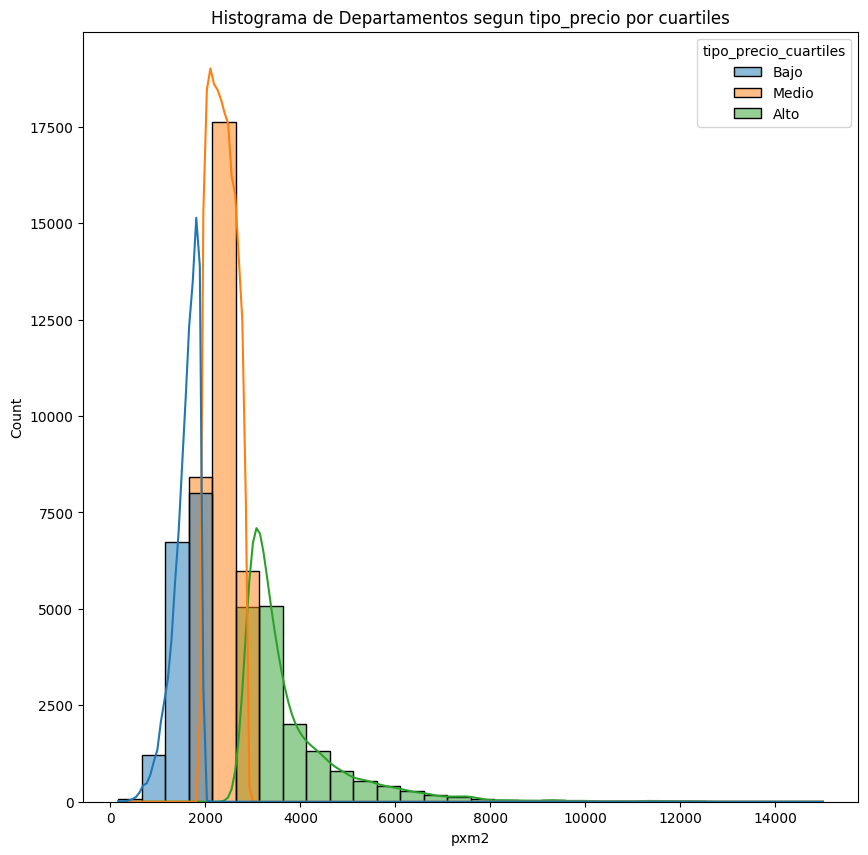

In [180]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Histograma de Departamentos segun tipo_precio por cuartiles')
sns.histplot(data = viviendas_caba_train_depto, x ='pxm2', hue = 'tipo_precio_cuartiles', bins=30, kde=True)
plt.show()

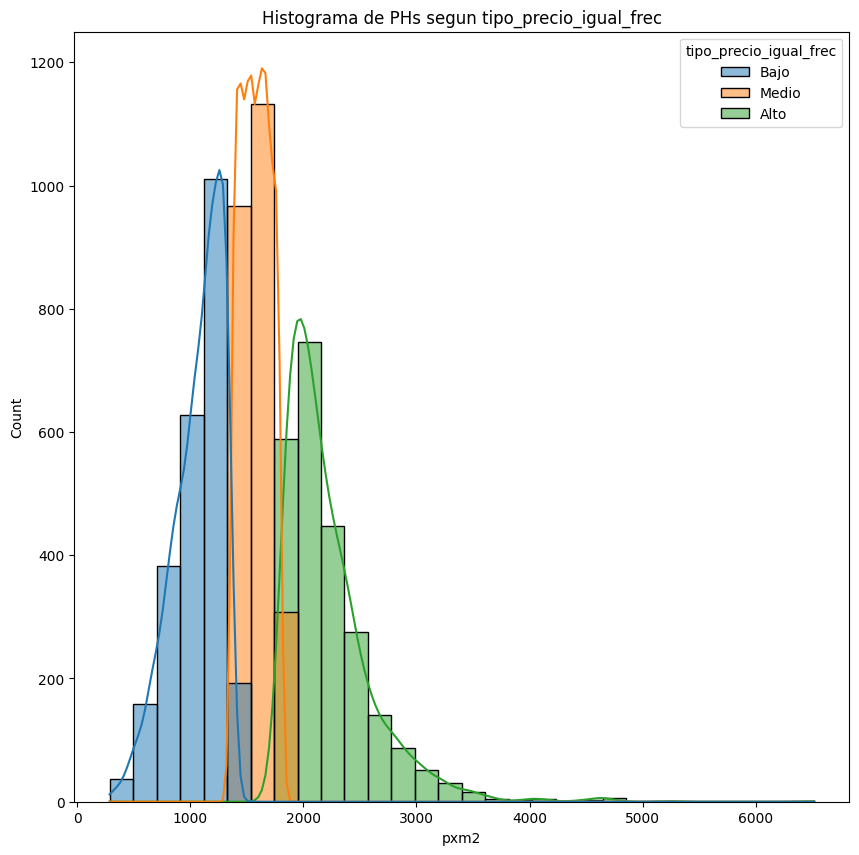

In [181]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Histograma de PHs segun tipo_precio_igual_frec')
sns.histplot(data = viviendas_caba_train_ph, x ='pxm2', hue = 'tipo_precio_igual_frec', bins=30, kde=True)
plt.show()

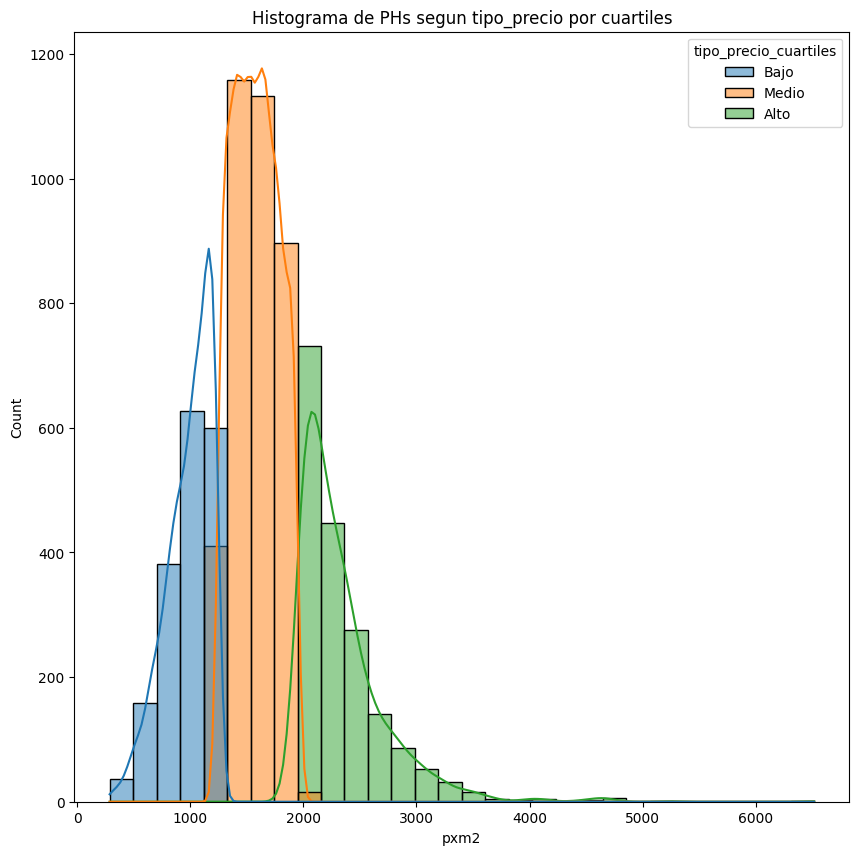

In [182]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Histograma de PHs segun tipo_precio por cuartiles')
sns.histplot(data = viviendas_caba_train_ph, x ='pxm2', hue = 'tipo_precio_cuartiles', bins=30, kde=True)
plt.show()

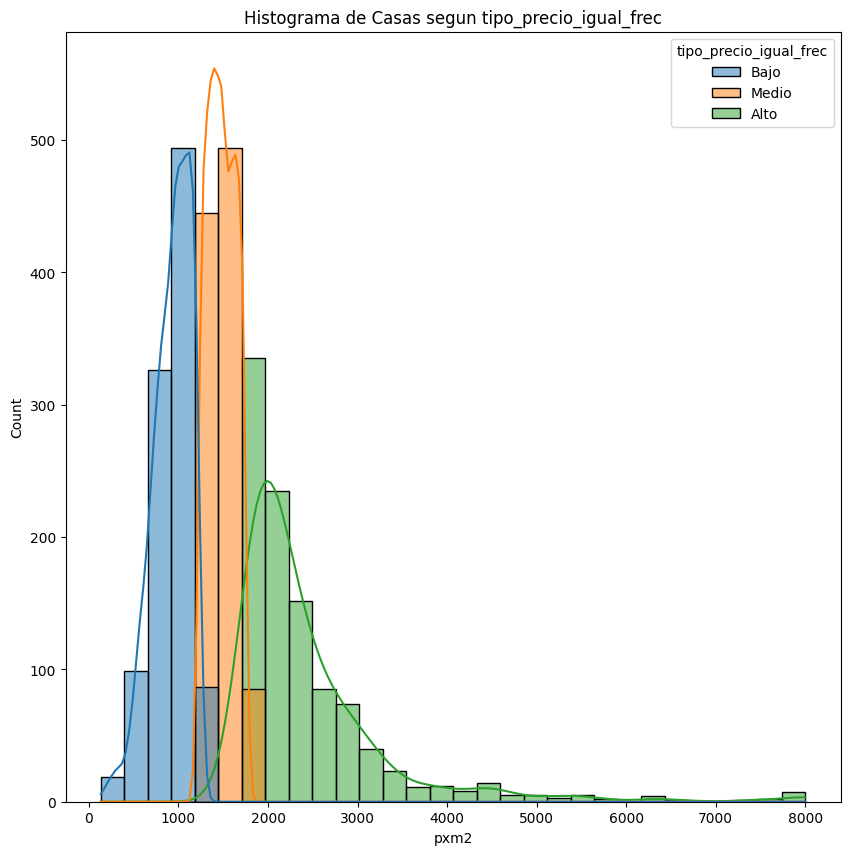

In [183]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Histograma de Casas segun tipo_precio_igual_frec')
sns.histplot(data = viviendas_caba_train_casa, x ='pxm2', hue = 'tipo_precio_igual_frec', bins=30, kde=True)
plt.show()

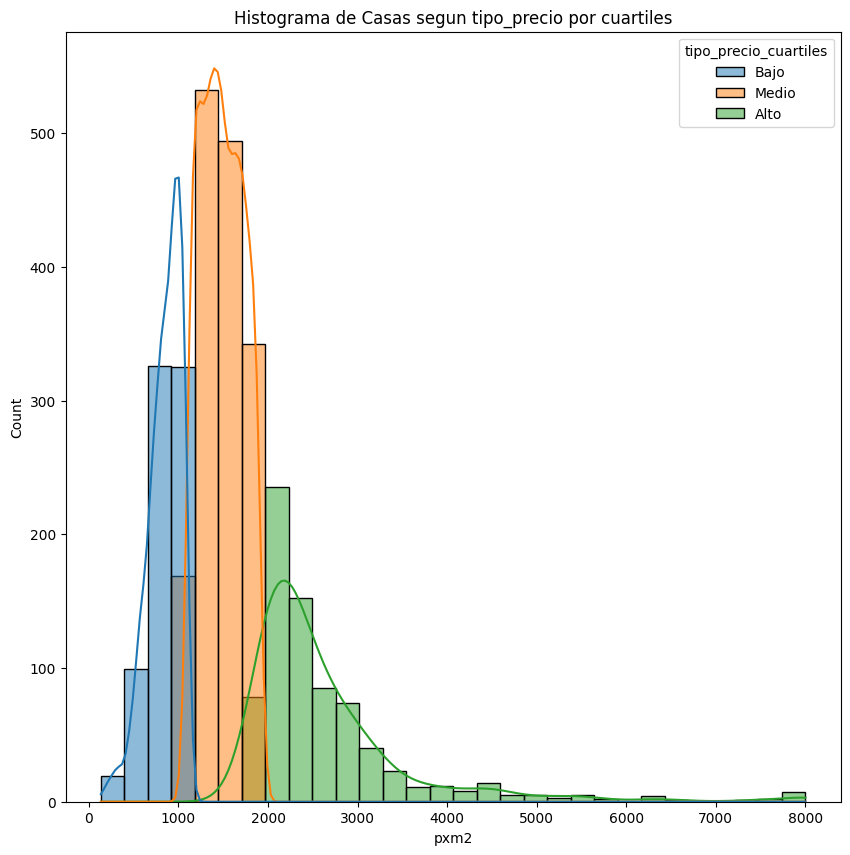

In [184]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Histograma de Casas segun tipo_precio por cuartiles')
sns.histplot(data = viviendas_caba_train_casa, x ='pxm2', hue = 'tipo_precio_cuartiles', bins=30, kde=True)
plt.show()

De los graficos anteriores podemos concluir:
+ Hay muchos mas Departamentos que Casas o PHs, por lo cual vamos a predecir teniendo en cuenta el tipo de propiedad.
+ Vemos que para todo tipo de propiedad, se agrupan muchas propiedades alrededor de los 1600 U$S/m2
+ Por lo anterior, decidimos utilizar el binning por cuartiles, ya que es esperable que de agarrar una propiedad, esta sea de tipo de precio Medio

Procedemos a agregar estos datos en los datasets de entrenamiento. Para el dataset de test, vamos a dividir los mismos segun los bins 

In [185]:
viviendas_caba_train.loc[viviendas_caba_train_depto.index,"tipo_precio"] = viviendas_caba_train_depto["tipo_precio_cuartiles"] 
viviendas_caba_train.loc[viviendas_caba_train_ph.index,"tipo_precio"] = viviendas_caba_train_ph["tipo_precio_cuartiles"] 
viviendas_caba_train.loc[viviendas_caba_train_casa.index,"tipo_precio"] = viviendas_caba_train_casa["tipo_precio_cuartiles"] 

lista_bins_depto = list(viviendas_caba_train_depto_bins_cuartiles)
lista_bins_depto[0] = 0 #Modificamos inicio bin
lista_bins_depto[3] = np.Infinity

lista_bins_ph = list(viviendas_caba_train_ph_bins_cuartiles)
lista_bins_ph[0] = 0
lista_bins_ph[3] = np.Infinity


lista_bins_casa = list(viviendas_caba_train_casa_bins_cuartiles)
lista_bins_casa[0] = 0
lista_bins_casa[3] = np.Infinity


viviendas_caba_test_depto = viviendas_caba_test.loc[viviendas_caba_test["property_type"]=="Departamento"].copy()
viviendas_caba_test_depto["tipo_precio"] = pd.cut(viviendas_caba_test_depto["pxm2"], bins=lista_bins_depto, labels=labels)

viviendas_caba_test_ph = viviendas_caba_test.loc[viviendas_caba_test["property_type"]=="PH"].copy()
viviendas_caba_test_ph["tipo_precio"] = pd.cut(viviendas_caba_test_ph["pxm2"], bins=lista_bins_ph, labels=labels)

viviendas_caba_test_casa = viviendas_caba_test.loc[viviendas_caba_test["property_type"]=="Casa"].copy()
viviendas_caba_test_casa["tipo_precio"] = pd.cut(viviendas_caba_test_casa["pxm2"], bins=lista_bins_casa, labels=labels)

viviendas_caba_test.loc[viviendas_caba_test_depto.index,"tipo_precio"] = viviendas_caba_test_depto["tipo_precio"] 
viviendas_caba_test.loc[viviendas_caba_test_ph.index,"tipo_precio"] = viviendas_caba_test_ph["tipo_precio"] 
viviendas_caba_test.loc[viviendas_caba_test_casa.index,"tipo_precio"] = viviendas_caba_test_casa["tipo_precio"] 



viviendas_caba_train = viviendas_caba_train.drop(columns=['tipo_precio_igual_frec', 'tipo_precio_cuartiles'], axis = 0, inplace=False).copy()



Ahora vamos a ver como se distribuyen las propiedades segun su tipo de precio en CABA.

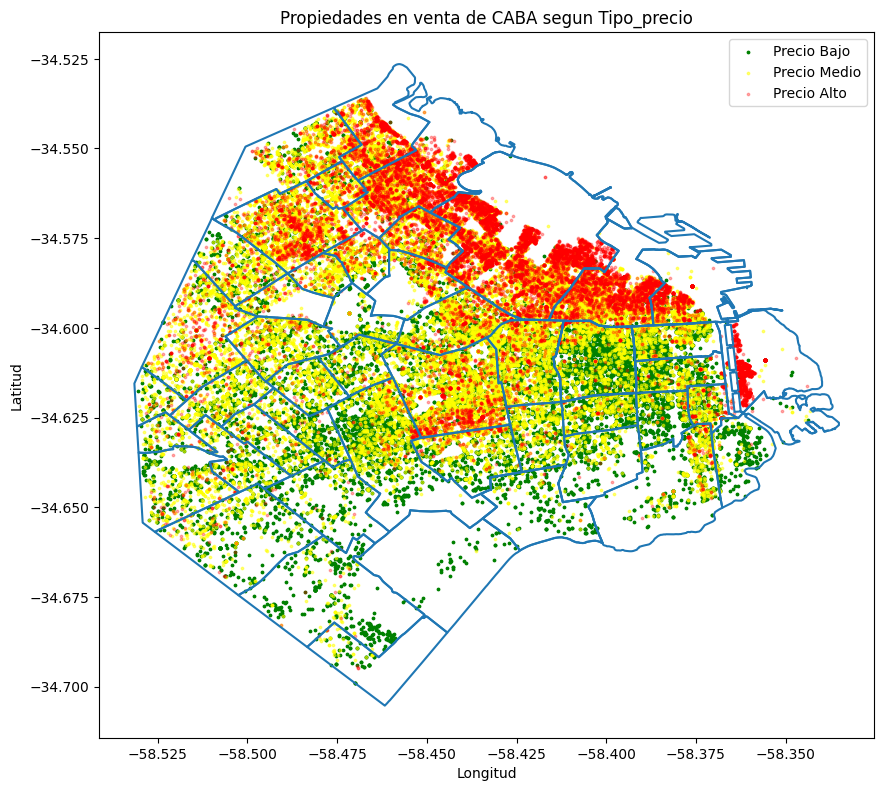

In [186]:
fig, ax = plt.subplots(figsize=(10,10))
ax.set_title('Propiedades en venta de CABA segun Tipo_precio')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')
poly.boundary.plot(ax=ax) #CABA
viviendas_caba_train_bajo = viviendas_caba_train[viviendas_caba_train['tipo_precio'] == 'Bajo']
viviendas_caba_train_medio = viviendas_caba_train[viviendas_caba_train['tipo_precio'] == 'Medio']
viviendas_caba_train_alto = viviendas_caba_train[viviendas_caba_train['tipo_precio'] == 'Alto']
puntos_precio_bajo = gp.GeoDataFrame(viviendas_caba_train_bajo, geometry=gp.points_from_xy(viviendas_caba_train_bajo.longitud,viviendas_caba_train_bajo.latitud)) 
puntos_precio_medio = gp.GeoDataFrame(viviendas_caba_train_medio, geometry=gp.points_from_xy(viviendas_caba_train_medio.longitud,viviendas_caba_train_medio.latitud)) 
puntos_precio_alto = gp.GeoDataFrame(viviendas_caba_train_alto, geometry=gp.points_from_xy(viviendas_caba_train_alto.longitud,viviendas_caba_train_alto.latitud)) 
puntos_precio_bajo.plot(ax=ax,markersize=3, label = 'Precio Bajo', color="green")
puntos_precio_medio.plot(ax=ax,markersize=3, label = 'Precio Medio', color="yellow", alpha = 0.5)
puntos_precio_alto.plot(ax=ax,markersize=3,label = 'Precio Alto', color="red", alpha=0.3)
plt.legend()

Se puede observar que en los barrios pertenecientes a la zona norte tienen mucha mas densidad de propiedades, lo cual tiene sentido dado que constantemente se esta construyendo en esos lugares.  
A su vez, en la zona meridional y sur hay menos propiedades en venta pero a mejor precio.  

## b. Entrenamiento y predicción

Vamos a entrenar modelos para intentar predecir el tipo de precio de un set de propiedades y tambien vamos corroborar la eficiencia de los mismos.  
Antes de ello, vamos a hacer una serie de transformaciones de los dataset.

In [187]:
ds_modelos = viviendas_caba_train.copy()
columnas_train = ['start_date','end_date','property_price','property_title','geometry','pxm2']
ds_modelos['property_rooms'] = ds_modelos['property_rooms'].astype(int)
ds_modelos['property_bedrooms'] = ds_modelos['property_bedrooms'].astype(int)
ds_modelos['property_surface_total'] = ds_modelos['property_surface_total'].astype(int)
ds_modelos['property_surface_covered'] = ds_modelos['property_surface_covered'].astype(int)
ds_modelos = ds_modelos.drop(columns=columnas_train, axis='columns', inplace=False).copy()

Corroboramos que la distribución de clases en los datasets sea la misma que la de la alternativa elegida en el punto 3.a).

In [188]:
ds_modelos['tipo_precio'].value_counts(normalize=True)*100

Medio    50.011440
Bajo     25.008412
Alto     24.980149
Name: tipo_precio, dtype: float64

In [189]:
viviendas_caba_test['tipo_precio'].value_counts(normalize=True)*100

Medio    49.736219
Bajo     25.328381
Alto     24.935401
Name: tipo_precio, dtype: float64

In [190]:
columnas_test = ['start_date','end_date','property_price','property_title','pxm2', 'geometry']
viviendas_caba_test = viviendas_caba_test.drop(columns=columnas_test, axis='columns', inplace=False).copy()


A los fines de poder utilizar el arbol de decision, vamos a sacar del dataset de test aquellas filas con valores NaN.

In [191]:
ds_modelos = pd.get_dummies(ds_modelos, columns=['property_type', 'barrio'])
viviendas_caba_test = pd.get_dummies(viviendas_caba_test, columns=['property_type', 'barrio'])
viviendas_caba_test['barrio_Catalinas'] = 0 #Porque no hay ninguna propiedad en el barrio de Catalinas en el dataset de test

columnas = ds_modelos.columns.tolist()
ds_modelos = ds_modelos[columnas]
viviendas_caba_test = viviendas_caba_test[columnas]

y_train = ds_modelos['tipo_precio'].copy()
y_test = viviendas_caba_test['tipo_precio'].copy()
x_train = ds_modelos.drop(columns=['tipo_precio'], axis='columns', inplace=False).copy()
x_test = viviendas_caba_test.drop(columns=['tipo_precio'], axis='columns', inplace=False).copy()





### Modelo 1: Arbol de decisión

Los arboles de decision basan sus predicciones en funcion de nodos, los cuales estan basados en todos los atributos del dataset.  
A modo de introducción, vamos a hacer una prediccion con un arbol de decision que tenga los parametros por default.

In [192]:
arbol_default = DecisionTreeClassifier(random_state= 42)
arbol_default.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

Vamos a probarlo con el dataset de train y el dataset de test, utilizando como metrica la F1 Score, la cual relaciona tanto Precision como Recall.

              precision    recall  f1-score   support

        Alto       0.97      0.99      0.98     18561
        Bajo       0.97      0.99      0.98     18582
       Medio       0.99      0.97      0.98     37160

    accuracy                           0.98     74303
   macro avg       0.97      0.98      0.98     74303
weighted avg       0.98      0.98      0.98     74303

F1-Score: 0.9782377678296538


Text(50.722222222222214, 0.5, 'Realidad')

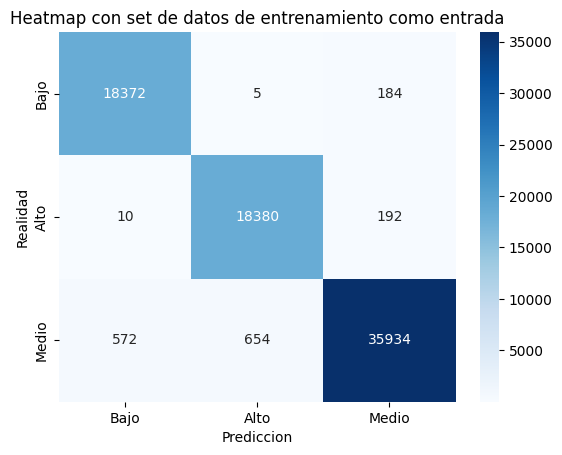

In [193]:
arbol_default.fit(x_train,y_train)
y_pred_train = arbol_default.predict(x_train)
labels = ['Bajo', 'Alto', 'Medio']

print(classification_report(y_train,y_pred_train))
print('F1-Score: {}'.format(f1_score(y_train,y_pred_train, average='weighted')))

cm = confusion_matrix(y_train,y_pred_train)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g', xticklabels=labels, yticklabels=labels).set(title="Heatmap con set de datos de entrenamiento como entrada")
plt.xlabel('Prediccion')
plt.ylabel('Realidad')

              precision    recall  f1-score   support

        Alto       0.69      0.71      0.70      4632
        Bajo       0.68      0.69      0.68      4705
       Medio       0.72      0.71      0.72      9239

    accuracy                           0.70     18576
   macro avg       0.70      0.70      0.70     18576
weighted avg       0.71      0.70      0.71     18576

F1-Score: 0.7050744790547199


Text(50.722222222222214, 0.5, 'Realidad')

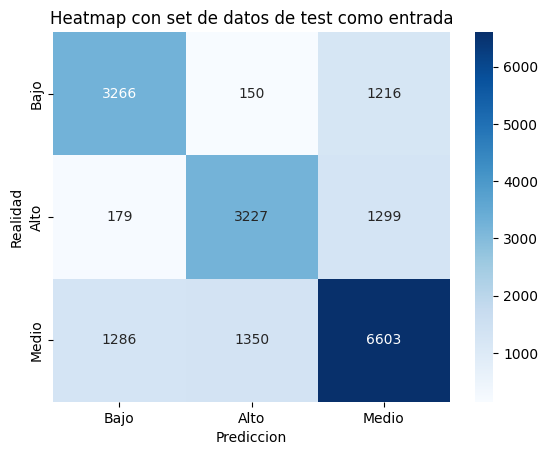

In [194]:
y_pred_test = arbol_default.predict(x_test)
labels = ['Bajo', 'Alto', 'Medio']

print(classification_report(y_test,y_pred_test))
print('F1-Score: {}'.format(f1_score(y_test,y_pred_test, average='weighted')))

cm = confusion_matrix(y_test,y_pred_test)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g', xticklabels=labels, yticklabels=labels).set(title="Heatmap con set de datos de test como entrada")
plt.xlabel('Prediccion')
plt.ylabel('Realidad')

Vemos que para el dataset de test, nos da una metrica F1 de 0.67. Claramente podemos observar que se overfittea cuando contrastamos con el dataset de train, pero que no es el caso para el dataset de test.  
Observamos ademas que todas las clases tienen metricas similares. La clase Medio tiene mejores metricas, estimamos que esto se debe a la cantidad de muestras.

Ahora a buscar la mejor combinacion de hiperparametros utilizando K-fold Cross Validation y buscando los mismos con Random Search.  
Por defecto, vamos a dejar la cantidad de folds en 5, luego veremos si podemos mejorar la busqueda de parametros utilizando Grid Search.  
Los hiperparametros del arbol de decision a maximizar son:
+ Criterio: Es el parametro para medir la calidad de la clasificacion. Vamos a hacer que se decida entre Gini o Entropy porque Log Loss no lo conocemos.
+ Splitter: Es el parametro que define la forma de seleccionar categorias de nodos. Vamos a dejarlo por defecto en Best.
+ Max Depth: Es el parametro que, si se lo define, limita la profundidad del arbol. Por defecto deja que el arbol se extienda hasta que sus hojas sean puras, pero esto claramente puede generar un arbol muy grande innecesariamente.
+ Min Samples Split: Es el parametro que define el numero minimo de muestras necesarias para distinguir un nodo interno. Vamos a hacer que pruebe entre valores de 1 a 100.
+ Min Samples Leaf: Es el parametro qe define la minima cantidad de muestras necesarias para un nodo hoja. Igual que el anterior, vamos a hacer que ruebe entre valores de 2 a 100.
+ Max Features: Es el parametro que define la cantidad de atributos que deben tenerse en cuenta al clasificar. Vamos a dejar que utilice todos los atributos, que es el valor por defecto.
+ Random State: Es el parametro que define la semilla del generador de numeros aleatorios. Vamos a setearlo en 42.
+ Max Leaf Nodes: Es el parametro que define la cantidad maxima de nodos hoja. Por defecto no hay limite, asi que vamos a dejarlo asi.
+ CCP Alpha: Es un parametro que define la poda de sub arboles dentro del arbol de decision. Vamos a hacer que pruebe entre 0 y 0,1 cada 0,005.

La metrica a maximizar sera el F1 Score, para ser consistentes con lo que venimos haciendo.
Al ser una prediccion multiclase, tenemos que elegir como va a calcular el promedio para cada clase, en nuestro caso vamos a definirla como `weighted` debido a que nuestra entrada de clases esta desbalanceada (tenemos una porcion mucho mas grande de tipo de precio Medio que del resto).

In [195]:
#Cantidad de iteraciones
n = 100

#Conjunto de parámetros que queremos usar
params = {'criterion':['gini','entropy'],
            'min_samples_leaf':list(range(1,50)),
            'min_samples_split': list(range(2,50)),
            'ccp_alpha':np.linspace(0,0.1,20),
            }
                
#Cantidad de splits para el Cross Validation
folds = 5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = DecisionTreeClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score, average='weighted')

#Random Search Cross Validation
randomcv = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n,
                              n_jobs=-1,
                              random_state= 42) 

#Buscamos los hiperparamtros que optimizan F1 Score
randomcv.fit(x_train,y_train)

#GridSearch CV
#gridcv = GridSearchCV(estimator=base_tree ,param_grid=params,scoring=scorer_fn,cv=kfoldcv, n_jobs=-1) 

#gridcv.fit(x_train,y_train)

KeyboardInterrupt: 

In [ ]:
print(randomcv.best_params_)
print(randomcv.best_score_)
#print(gridcv.best_params_)
#print(gridcv.best_score_)

{'min_samples_split': 26, 'min_samples_leaf': 5, 'criterion': 'entropy', 'ccp_alpha': 0.0}
0.6634964891749389


Vemos que la mejor metrica de F1 Score que podemos conseguir es de 0.62, lo cual puede indicar que nuestro arbol tenga una mejor Precision que Recall o viceversa.  
Vamos a armar un arbol predictor con estos parametros y vamos a ver como predice tomando como entrada los valores de entrenamiento.

In [ ]:
arbol_predictor_randomcv=randomcv.best_estimator_
arbol_predictor_randomcv.fit(x_train,y_train)

arbol_predictor_randomcv.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 5,
 'min_samples_split': 26,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

              precision    recall  f1-score   support

        Alto       0.79      0.77      0.78     18561
        Bajo       0.78      0.75      0.77     18582
       Medio       0.79      0.83      0.81     37160

    accuracy                           0.79     74303
   macro avg       0.79      0.78      0.79     74303
weighted avg       0.79      0.79      0.79     74303

F1-Score: 0.7918825747853839


Text(50.722222222222214, 0.5, 'Realidad')

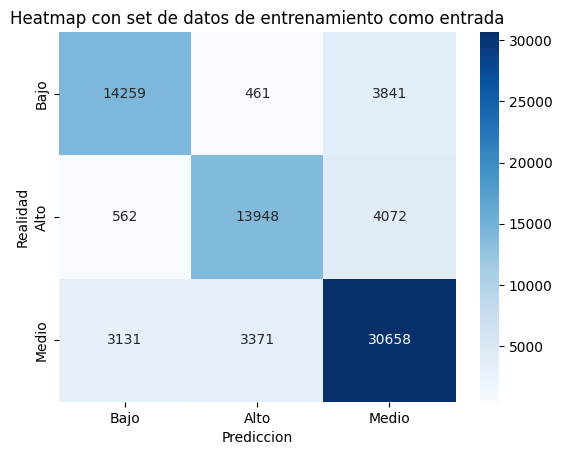

In [ ]:
y_pred_train = arbol_predictor_randomcv.predict(x_train)
labels = ['Bajo', 'Alto', 'Medio']

print(classification_report(y_train,y_pred_train))
print('F1-Score: {}'.format(f1_score(y_train,y_pred_train, average='weighted')))

cm = confusion_matrix(y_train,y_pred_train)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g', xticklabels=labels, yticklabels=labels).set(title="Heatmap con set de datos de entrenamiento como entrada")
plt.xlabel('Prediccion')
plt.ylabel('Realidad')


Del heatmap anterior, podemos ver que nuestro modelo tiene una tendencia a clasificar de manera desbalanceada, ya que se ve una diferencia de metrica importante entre clases.  
A su vez, el modelo clasifica mejor aquellas viviendas cuyo tipo de precio es Medio.
Ahora vamos a ver como predice con nuestra entrada de test.

              precision    recall  f1-score   support

        Alto       0.66      0.64      0.65      4632
        Bajo       0.67      0.63      0.65      4705
       Medio       0.68      0.71      0.70      9239

    accuracy                           0.67     18576
   macro avg       0.67      0.66      0.66     18576
weighted avg       0.67      0.67      0.67     18576

F1-Score: 0.6728699825210264


Text(50.722222222222214, 0.5, 'Realidad')

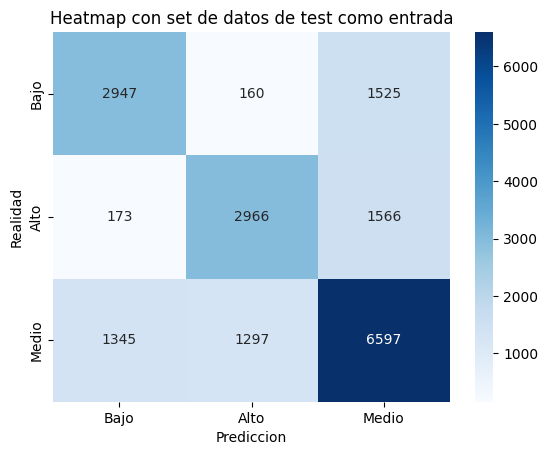

In [ ]:
y_pred_test = arbol_predictor_randomcv.predict(x_test)
labels = ['Bajo', 'Alto', 'Medio']

print(classification_report(y_test,y_pred_test))
print('F1-Score: {}'.format(f1_score(y_test,y_pred_test, average='weighted')))

cm = confusion_matrix(y_test,y_pred_test)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g', xticklabels=labels, yticklabels=labels).set(title="Heatmap con set de datos de test como entrada")
plt.xlabel('Prediccion')
plt.ylabel('Realidad')

Podemos observar en este caso que para el dataset de entrada no se overfittea, y que a su vez la metrica F1 nos da parecida aunque un poco menor.  
A su vez, seguimos viendo una diferencia de metricas, donde se pondera de mejor manera aquellas propiedades de tipo de precio Medio.  

Ahora vamos a ver que pasa con nuestra metrica si entrenamos el arbol con una gran cantidad de folds.

In [ ]:
# Spits que respeten la proporción delas clases
kfoldcv =StratifiedKFold(n_splits=50) 
 
#Creo árbol con los mejores hiperparámetros 
arbolcv=DecisionTreeClassifier(random_state= 42)

#Selecciono métrica F1-Score
scorer_fn = make_scorer(sk.metrics.f1_score, average='weighted')

#Hago CV
resultados = cross_validate(arbolcv,x_train, y_train, cv=kfoldcv,scoring=scorer_fn,return_estimator=True, n_jobs=-1)

#Selecciono el arbol con mejor performance
metricsCV=resultados['test_score']

In [ ]:
metricsCV

array([0.70032612, 0.69936131, 0.67906236, 0.69059282, 0.70376963,
       0.70225499, 0.71390654, 0.70315118, 0.69385882, 0.69670738,
       0.68934278, 0.70161827, 0.69711026, 0.69942923, 0.70340935,
       0.70473134, 0.71285515, 0.70685883, 0.69541959, 0.70743708,
       0.71362379, 0.68732474, 0.69582159, 0.69382699, 0.72020541,
       0.70614515, 0.71176476, 0.7060305 , 0.70385976, 0.69148964,
       0.69521266, 0.72073533, 0.69532423, 0.72300238, 0.70819646,
       0.71789759, 0.70964082, 0.69688374, 0.71263135, 0.71400099,
       0.69535807, 0.7034367 , 0.70466727, 0.71396732, 0.71816118,
       0.71101885, 0.66930105, 0.7263012 , 0.73635196, 0.70673488])

[Text(0.5, 1.0, 'Boxplot de F1 Score para CV'), Text(0.5, 0, 'F1 Score')]

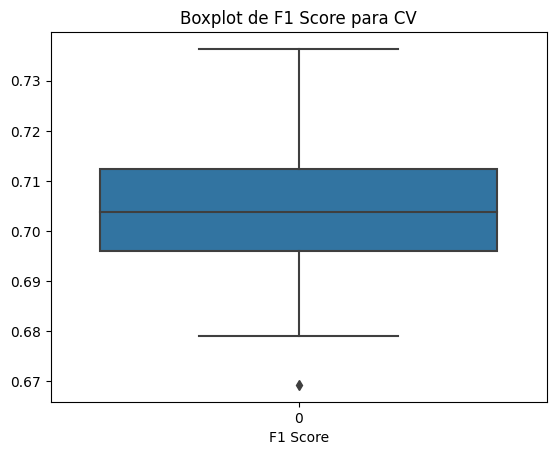

In [ ]:
sns.boxplot(metricsCV).set(title="Boxplot de F1 Score para CV",xlabel='F1 Score')

Vemos que entrenar el arbol con muchisimos folds puede levantar la media de la metrica F1. Vamos a predecir con el árbol de mayor metrica.

              precision    recall  f1-score   support

        Alto       0.69      0.70      0.70      4632
        Bajo       0.68      0.68      0.68      4705
       Medio       0.73      0.71      0.72      9239

    accuracy                           0.70     18576
   macro avg       0.70      0.70      0.70     18576
weighted avg       0.70      0.70      0.70     18576

F1-Score: 0.7038775368622544


Text(50.722222222222214, 0.5, 'Realidad')

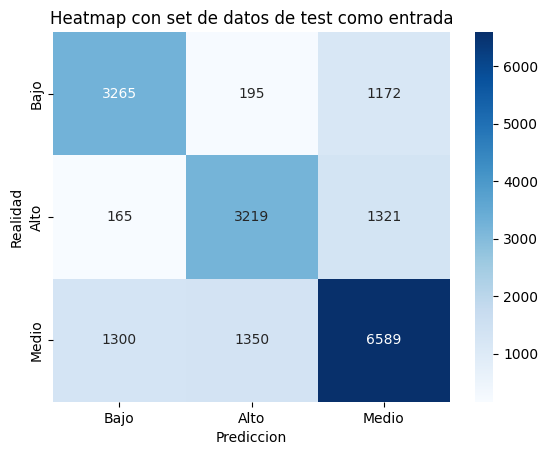

In [ ]:
arbol_mejor_performance_cv=resultados['estimator'][np.where(metricsCV==max(metricsCV))[0][0]]
y_pred_test_cv = arbol_mejor_performance_cv.predict(x_test)
labels = ['Bajo', 'Alto', 'Medio']

print(classification_report(y_test,y_pred_test_cv))
print('F1-Score: {}'.format(f1_score(y_test,y_pred_test_cv, average='weighted')))

cm = confusion_matrix(y_test,y_pred_test_cv)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g', xticklabels=labels, yticklabels=labels).set(title="Heatmap con set de datos de test como entrada")
plt.xlabel('Prediccion')
plt.ylabel('Realidad')

In [ ]:
feat_imps = arbol_mejor_performance_cv.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,columnas)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

barrio_Villa General Mitre: 8.796313835223307e-05
barrio_Paternal: 0.0001077847759131679
barrio_Catalinas: 0.00012853813537981357
barrio_Las Cañitas: 0.0001618240220409454
barrio_Liniers: 0.00017138200489411165
barrio_Parque Avellaneda: 0.00017598154690946457
barrio_Velez Sarsfield: 0.00018556060988038941
barrio_Belgrano: 0.00018907777977467195
barrio_Palermo: 0.00021926600091560784
barrio_San Telmo: 0.00022403777431854988
barrio_Abasto: 0.00027630581852955817
barrio_Villa Pueyrredón: 0.0003033217793843365
barrio_Boca: 0.00034350093617442206
barrio_Congreso: 0.000345793988560871
barrio_Villa Ortuzar: 0.0003488615034062152
barrio_San Cristobal: 0.00038403627809373335
barrio_Centro / Microcentro: 0.0003907588411224167
barrio_Nuñez: 0.0004143887695937845
barrio_Villa Riachuelo: 0.00041564226020410547
property_type_PH: 0.0004191229911055011
barrio_Parque Chacabuco: 0.00048077269098025367
barrio_Villa Luro: 0.0005421208969536267
barrio_Tribunales: 0.0005490553978086778
barrio_Monserrat: 0.0

De aca podemos concluir que para este modelo no hace mucha diferencia tener en cuenta mas folds. A su vez, no se pudo optimizar los hiperparametros de aquellos que vienen por defecto.    
Para nuestro caso es el mejor modelo el cual deja crecer el arbol hasta que sea puro, divide siempre en 2, cada hoja tiene una sola muestra y se tienen en cuenta todos los atributos.  
Vamos a graficar el mejor arbol obtenido por CrossValidation recortado.

In [ ]:
plt.figure(figsize=(100,100))

tree_plot=tree.plot_tree(arbol_mejor_performance_cv,
                         max_depth=2,
                         feature_names=x_train.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names=arbol_mejor_performance_cv.classes_)

plt.show(tree_plot)

In [ ]:
feat_imps = arbol_mejor_performance_cv.feature_importances_

for feat_imp,feat in sorted(zip(feat_imps,columnas)):
  if feat_imp>0:
    print('{}: {}'.format(feat,feat_imp))

### Modelo 2: Random Forest

El Random Forest es un metodo basado en tener muchos arboles de decision mediocres y someterlos a votación para predecir  
A modo de introducción, vamos a hacer una prediccion con un Random Forest que tenga los parametros por default.

In [ ]:
rf_default = RandomForestClassifier(random_state= 42)
rf_default.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Vamos a probarlo con el dataset de train y el dataset de test, utilizando como metrica la F1 Score.

              precision    recall  f1-score   support

        Alto       0.98      0.98      0.98     18561
        Bajo       0.98      0.97      0.98     18582
       Medio       0.98      0.98      0.98     37160

    accuracy                           0.98     74303
   macro avg       0.98      0.98      0.98     74303
weighted avg       0.98      0.98      0.98     74303

F1-Score: 0.9782367426995848


Text(50.722222222222214, 0.5, 'Realidad')

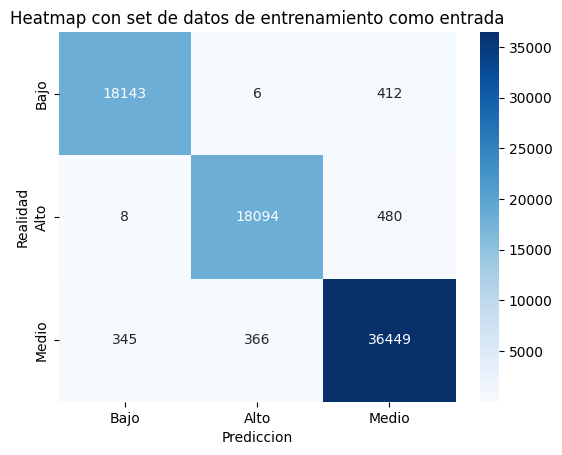

In [ ]:
rf_default.fit(x_train,y_train)
y_pred_train = rf_default.predict(x_train)
labels = ['Bajo', 'Alto', 'Medio']

print(classification_report(y_train,y_pred_train))
print('F1-Score: {}'.format(f1_score(y_train,y_pred_train, average='weighted')))

cm = confusion_matrix(y_train,y_pred_train)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g', xticklabels=labels, yticklabels=labels).set(title="Heatmap con set de datos de entrenamiento como entrada")
plt.xlabel('Prediccion')
plt.ylabel('Realidad')

              precision    recall  f1-score   support

        Alto       0.77      0.68      0.72      4632
        Bajo       0.77      0.70      0.73      4705
       Medio       0.73      0.80      0.76      9239

    accuracy                           0.75     18576
   macro avg       0.75      0.73      0.74     18576
weighted avg       0.75      0.75      0.74     18576

F1-Score: 0.7448661424256348


Text(50.722222222222214, 0.5, 'Realidad')

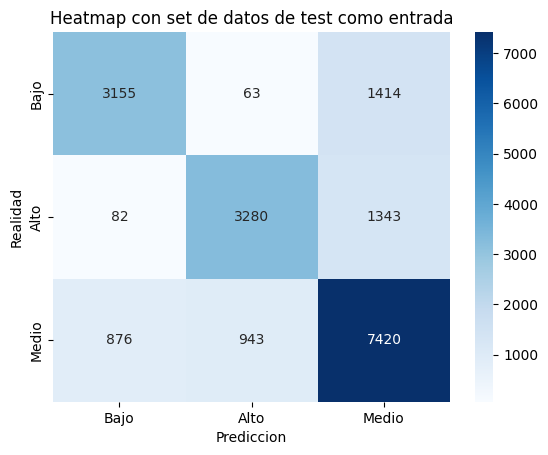

In [ ]:
y_pred_test = rf_default.predict(x_test)
labels = ['Bajo', 'Alto', 'Medio']

print(classification_report(y_test,y_pred_test))
print('F1-Score: {}'.format(f1_score(y_test,y_pred_test, average='weighted')))

cm = confusion_matrix(y_test,y_pred_test)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g', xticklabels=labels, yticklabels=labels).set(title="Heatmap con set de datos de test como entrada")
plt.xlabel('Prediccion')
plt.ylabel('Realidad')

Vemos que es bastante mejor que utilizar un arbol de decision, y ademas se sigue observando una ligera mejor prediccion para tipo de precio Medio.  
A su vez, como en arboles de decision, se overfittea cuando se contrasta con el dataset de entrenamiento.

De manera analoga al modelo anterior, vamos a buscar la mejor combinacion de hiperparametros utilizando K-fold Cross Validation y buscando los mismos con Random Search.  
Por defecto, vamos a dejar la cantidad de folds en 5, luego veremos si podemos mejorar la busqueda de parametros utilizando Grid Search.  
Los hiperparametros del arbol de decision a maximizar son:
+ N_Estimators: Es la cantidad de arboles que va a tener el bosque, vamos a tomar de 100 a 500 arboles.
+ Criterio: Es el parametro para medir la calidad de la clasificacion. Vamos a hacer que se decida entre Gini o Entropy porque Log Loss no lo conocemos.
+ Max Depth: Es el parametro que, si se lo define, limita la profundidad del arbol. Por defecto deja que el arbol se extienda hasta que sus hojas sean puras, pero esto claramente puede generar un arbol muy grande innecesariamente.
+ Min Samples Split: Es el parametro que define el numero minimo de muestras necesarias para distinguir un nodo interno por arbol. Vamos a hacer que pruebe entre valores bajos.
+ Min Samples Leaf: Es el parametro qe define la minima cantidad de muestras necesarias para un nodo hoja por arbol. Igual que el anterior, vamos a hacer que pruebe entre valores bajos.
+ Max Features: Es el parametro que define la cantidad de atributos que deben tenerse en cuenta al clasificar por cada arbol. Vamos a dejar que busque entre raiz(atributos totales) y log2(atributos totales)
+ Random State: Es el parametro que define la semilla del generador de numeros aleatorios. Vamos a dejarlo setearlo en 42.
+ Max Leaf Nodes: Es el parametro que define la cantidad maxima de nodos hoja por arbol. Por defecto no hay limite, asi que vamos a dejarlo asi.
+ CCP Alpha: Es un parametro que define la poda de sub arboles dentro del arbol de decision por arbol. Vamos a dejarlo en 0, que es como viene por defecto.
+ Bootstrap: Es un parametro que define si se va a aplicar bootstrapping a las muestras,. Por defecto no se hace bootstrapping, lo vamos a dejar asi.

La metrica a maximizar sera el F1 Score, para ser consistentes con lo que venimos haciendo.
Al ser una prediccion multiclase, tenemos que elegir como va a calcular el promedio para cada clase, en nuestro caso vamos a definirla como `weighted` debido a que nuestra entrada de clases esta desbalanceada (tenemos una porcion mucho mas grande de tipo de precio Medio que del resto).

In [ ]:
#Cantidad de iteraciones
n = 20

#Conjunto de parámetros que queremos usar
params = {'criterion':['gini','entropy'],
            'max_features':['sqrt', 'log2'],   
            'min_samples_leaf': [1,2,3,5,7,10,15],               
            'min_samples_split':[2,4,6,8,10,12,14,16],
            'n_estimators':[100,200,300,500]
            }

#Cantidad de splits para el Cross Validation
folds = 5

#Kfold estratificado
kfoldcv = StratifiedKFold(n_splits=folds)

#Clasificador
base_tree = RandomForestClassifier() 

#Metrica que quiero optimizar F1 Score
scorer_fn = make_scorer(sk.metrics.f1_score, average='weighted')

#Random Search Cross Validation
randomcvRF = RandomizedSearchCV(estimator=base_tree,
                              param_distributions = params,
                              scoring=scorer_fn,
                              cv=kfoldcv,
                              n_iter=n,
                              n_jobs=-1,
                              random_state=42) 

randomcvRF.fit(x_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=RandomForestClassifier(), n_iter=20, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_features': [None, 'sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 3, 5, 7, 10,
                                                             15],
                                        'min_samples_split': [2, 4, 6, 8, 10,
                                                              12, 14, 16],
                                        'n_estimators': [100, 200, 300, 500]},
                   random_state=42,
                   scoring=make_scorer(f1_score, average=weighted))

In [ ]:
print(randomcvRF.best_params_)
print(randomcvRF.best_score_)

{'n_estimators': 500, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': None, 'criterion': 'gini'}
0.7389193938486742


In [ ]:
rf_predictor_randomcv=RandomForestClassifier().set_params(**randomcvRF.best_params_)
rf_predictor_randomcv.fit(x_train,y_train)

RandomForestClassifier(max_features=None, min_samples_leaf=2,
                       min_samples_split=6, n_estimators=500)

Vemos que para la metrica que seleccionamos, RF es un mejor predictor

              precision    recall  f1-score   support

        Alto       0.96      0.92      0.94     18561
        Bajo       0.95      0.91      0.93     18582
       Medio       0.92      0.97      0.95     37160

    accuracy                           0.94     74303
   macro avg       0.95      0.93      0.94     74303
weighted avg       0.94      0.94      0.94     74303

F1-Score: 0.9404485130482446


Text(50.722222222222214, 0.5, 'Realidad')

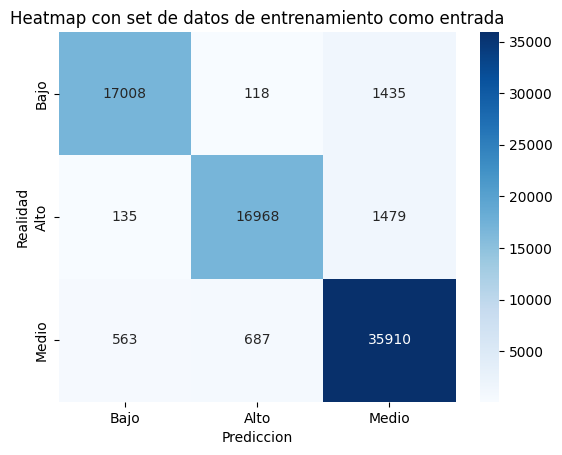

In [ ]:

y_pred_train = rf_predictor_randomcv.predict(x_train)
labels = ['Bajo', 'Alto', 'Medio']

print(classification_report(y_train,y_pred_train))
print('F1-Score: {}'.format(f1_score(y_train,y_pred_train, average='weighted')))

cm = confusion_matrix(y_train,y_pred_train)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g', xticklabels=labels, yticklabels=labels).set(title="Heatmap con set de datos de entrenamiento como entrada")
plt.xlabel('Prediccion')
plt.ylabel('Realidad')


Vemos claramente que RF overfittea cuando la entrada es el dataset de entrenamiento.

              precision    recall  f1-score   support

        Alto       0.78      0.69      0.73      4632
        Bajo       0.78      0.69      0.73      4705
       Medio       0.73      0.82      0.77      9239

    accuracy                           0.75     18576
   macro avg       0.76      0.73      0.74     18576
weighted avg       0.75      0.75      0.75     18576

F1-Score: 0.750520746938141


Text(50.722222222222214, 0.5, 'Realidad')

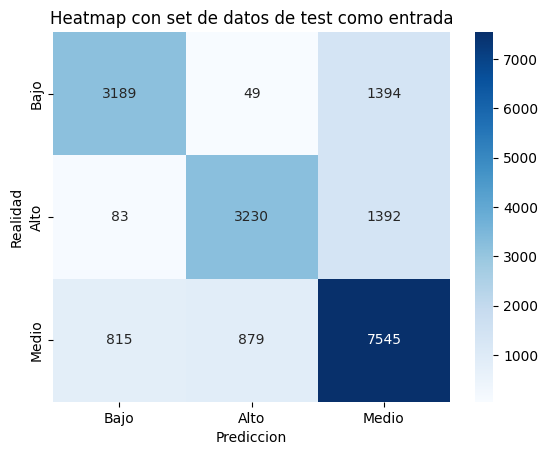

In [ ]:
y_pred_test = rf_predictor_randomcv.predict(x_test)
labels = ['Bajo', 'Alto', 'Medio']

print(classification_report(y_test,y_pred_test))
print('F1-Score: {}'.format(f1_score(y_test,y_pred_test, average='weighted')))

cm = confusion_matrix(y_test,y_pred_test)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g', xticklabels=labels, yticklabels=labels).set(title="Heatmap con set de datos de test como entrada")
plt.xlabel('Prediccion')
plt.ylabel('Realidad')

Vemos que RF es un predictor mucho mas balanceado que el Arbol de Decisiones y las metricas nos dan mejor.

In [ ]:
plt.figure(figsize=(100,100))

tree_plot=tree.plot_tree(rf_predictor_randomcv.estimators_[3],
                         max_depth=3,
                         feature_names=x_train.columns.to_list(),
                         filled=True,
                         rounded=True,
                         class_names=True)

plt.show(tree_plot)